In [1]:
import torch, os
import pandas as pd

from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
model = AutoModelForQuestionAnswering.from_pretrained("models/RoBERT.pth")
tokenizer = AutoTokenizer.from_pretrained("models/Tokenizer_RoBERT.pth/")

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at models/RoBERT.pth and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
df = pd.read_csv("yerdaulet_annot.csv")

train, val = train_test_split(df, test_size=0.2)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [4]:
train_encodings = tokenizer(list(train.context), list(train.question), max_length=512, truncation=True, padding='max_length', return_tensors='pt')

val_encodings = tokenizer(list(val.context), list(val.question), max_length=512, truncation=True, padding='max_length', return_tensors='pt')

In [5]:
def add_token_positions(encodings, df):
    start_positions = []
    end_positions = []


    for i in range(len(df['start_position'])):
        target_answer = df.at[i, "answer"]
        start = encodings.char_to_token(i, df['start_position'][i] + 0)
        end = encodings.char_to_token(i, df['end_position'][i] + 0)

        if end is None:
            end = encodings.char_to_token(i, df['end_position'][i] + 1)
        
        answer = tokenizer.decode(encodings['input_ids'][i][start:end])
        
        if target_answer.strip() == answer.strip():
            pass
        else:
            counter = 2
            while end is None:
                end = encodings.char_to_token(i, df['end_position'][i] + counter)
                if counter == 50:
                    break
                    
                counter += 1

            counter = 1
            while end is None:
                end = encodings.char_to_token(i, df['end_position'][i] - counter)
                counter += 1

                
        start_positions.append(start)
        end_positions.append(end)
    
    encodings.update({
        'start_positions': start_positions,
        'end_positions': end_positions
    })

In [6]:
add_token_positions(train_encodings, train)
add_token_positions(val_encodings, val)

In [7]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        
    def __len__(self, ):
        return len(self.encodings.input_ids)
    
    def __getitem__(self, x):
        return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}

In [8]:
vals = next(iter(SquadDataset(train_encodings)))

C:\Users\yerda\AppData\Local\Temp\ipykernel_22776\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}


In [9]:
vals['input_ids'];

In [10]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [11]:
def save_model(model_name, epoch, prev_loss, current_loss, model, tokenizer, optimizer):
    if prev_loss > current_loss:
        torch.save({
            "epoch": epoch,
            "model": "best_RoBERTa_model.pth",
            "tokenizer": "best_RoBERT_tokenizer.pth",
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/best_{model_name}.pt") # create models folder before! 
        print("The best model was saved!")
        prev_loss = current_loss
        model.save_pretrained("models/best_RoBERTa_model.pth")
        tokenizer.save_pretrained("models/best_RoBERT_tokenizer.pth")
    
    torch.save({
            "epoch": epoch,
            "model": "last_RoBERTa_model.pth",
            "tokenizer": "last_RoBERT_tokenizer.pth",
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/last_{model_name}.pt")
    model.save_pretrained("models/last_RoBERTa_model.pth")
    tokenizer.save_pretrained("models/last_RoBERT_tokenizer.pth")
    return prev_loss


os.makedirs("models", exist_ok=True)

In [12]:
model.train()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [13]:
num_epochs, prev_loss = 100, torch.inf
train_loss, val_loss = [], []


for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    loss_list, count = 0, 0
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, 
                        start_positions=start_positions,
                        end_positions=end_positions)
        
        loss = outputs[0]
        loss.backward()
        optim.step()
        
        loss_list += loss.item()
        count += 1
        
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss = loss_list/count
    train_loss.append(loss)
    model.eval()
    @torch.no_grad()
    def validation():
        loop = tqdm(val_loader)
        loss_list, count = 0, 0
        for batch in loop:            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, 
                            start_positions=start_positions,
                            end_positions=end_positions)
            
            loss = outputs[0]
            loss_list += loss.item()
            count += 1
            
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        return loss_list / count
    v_loss = validation()
    val_loss.append(v_loss)    
    prev_loss = save_model("RoBERTa", epoch, prev_loss, v_loss, model, tokenizer, optim)
    print(f"Epoch: {epoch} | Training loss {loss} | Validation loss {v_loss}")

  0%|                                                                                           | 0/66 [00:00<?, ?it/s]C:\Users\yerda\AppData\Local\Temp\ipykernel_22776\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}
Epoch 0:   2%|▉                                                              | 1/66 [00:02<02:41,  2.48s/it, loss=6.34]C:\Users\yerda\AppData\Local\Temp\ipykernel_22776\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████████████████████████████████████████████████████████| 17/17 

The best model was saved!
Epoch: 0 | Training loss 3.527042370854002 | Validation loss 3.2851467413060806


Epoch 1: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.32it/s, loss=2.73]


The best model was saved!
Epoch: 1 | Training loss 2.54295746124152 | Validation loss 3.207504384657916


Epoch 2: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=3.09]


Epoch: 2 | Training loss 1.8077199630665057 | Validation loss 3.493916385314044


Epoch 3: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=3.54]


The best model was saved!
Epoch: 3 | Training loss 1.086864920276584 | Validation loss 3.204213675330667


Epoch 4: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.26it/s, loss=3.62]


Epoch: 4 | Training loss 0.44588083988337807 | Validation loss 3.638382911682129


Epoch 5: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=3.64]


Epoch: 5 | Training loss 0.21981208223962423 | Validation loss 4.127550531836117


Epoch 6: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=2.97]


Epoch: 6 | Training loss 0.17474487234810085 | Validation loss 3.804668931400075


Epoch 7: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=6.14]


Epoch: 7 | Training loss 0.08907919941879244 | Validation loss 4.195129170137293


Epoch 8: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=5.77]


Epoch: 8 | Training loss 0.055314562590369445 | Validation loss 4.2458845587337715


Epoch 9: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=4.6]


Epoch: 9 | Training loss 0.03706731303827837 | Validation loss 4.343194246292114


Epoch 10: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=2.27]


Epoch: 10 | Training loss 0.030242237549938374 | Validation loss 3.8912817870869354


Epoch 11: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=3.78]


Epoch: 11 | Training loss 0.016729415220624738 | Validation loss 4.164072709925034


Epoch 12: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=4.6]


Epoch: 12 | Training loss 0.008738241304826894 | Validation loss 4.267514789805693


Epoch 13: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=3.6]


Epoch: 13 | Training loss 0.006900972876764806 | Validation loss 4.293209959478939


Epoch 14: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=1.99]


Epoch: 14 | Training loss 0.004507183927423533 | Validation loss 4.3819520964342


Epoch 15: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=3.58]


Epoch: 15 | Training loss 0.003549834853567352 | Validation loss 4.505458565319286


Epoch 16: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=4.44]


Epoch: 16 | Training loss 0.002361004598545454 | Validation loss 4.607528560301837


Epoch 17: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=7.01]


Epoch: 17 | Training loss 0.0019370700357478308 | Validation loss 4.729051211301019


Epoch 18: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=8.98]


Epoch: 18 | Training loss 0.0016953630787831958 | Validation loss 4.873315081876867


Epoch 19: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=5.19]


Epoch: 19 | Training loss 0.0013085359104011193 | Validation loss 4.744127511978149


Epoch 20: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=3.01]


Epoch: 20 | Training loss 0.0010337315469576315 | Validation loss 4.669773087782018


Epoch 21: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=3.92]


Epoch: 21 | Training loss 0.0006900627242540588 | Validation loss 4.74539199997397


Epoch 22: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=7.22]


Epoch: 22 | Training loss 0.00040125319025140595 | Validation loss 4.888493439730476


Epoch 23: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=4.59]


Epoch: 23 | Training loss 0.00033118845573026744 | Validation loss 4.839887226329131


Epoch 24: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=3.85]


Epoch: 24 | Training loss 0.000287430782036884 | Validation loss 4.829210295396693


Epoch 25: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=5.8]


Epoch: 25 | Training loss 0.00025952121794751184 | Validation loss 4.928402578129488


Epoch 26: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=5.12]


Epoch: 26 | Training loss 0.00022731094665659563 | Validation loss 4.921408765456256


Epoch 27: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.18it/s, loss=4.8]


Epoch: 27 | Training loss 0.00020667602108336393 | Validation loss 4.93284358697779


Epoch 28: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=5.01]


Epoch: 28 | Training loss 0.00018895220102532414 | Validation loss 4.957742424572215


Epoch 29: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=5.82]


Epoch: 29 | Training loss 0.00017134061134570265 | Validation loss 5.010937354143928


Epoch 30: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=8.14]


Epoch: 30 | Training loss 0.0001574972548593051 | Validation loss 5.1107188112595505


Epoch 31: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=2.88]


Epoch: 31 | Training loss 0.0001446052074794407 | Validation loss 4.933800290612614


Epoch 32: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=2.2]


Epoch: 32 | Training loss 0.0001328318693402142 | Validation loss 4.931157659081852


Epoch 33: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=7.21]


Epoch: 33 | Training loss 0.00012249040155714312 | Validation loss 5.123150769401999


Epoch 34: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=3.71]


Epoch: 34 | Training loss 0.00011372436617393484 | Validation loss 5.01623779184678


Epoch 35: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=3.74]


Epoch: 35 | Training loss 0.00010505379249838315 | Validation loss 5.032585228190703


Epoch 36: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=6.57]


Epoch: 36 | Training loss 9.703400130754083e-05 | Validation loss 5.145691535052131


Epoch 37: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=2.65]


Epoch: 37 | Training loss 8.903911814493107e-05 | Validation loss 5.0200689820682305


Epoch 38: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=4.17]


Epoch: 38 | Training loss 8.282236310399391e-05 | Validation loss 5.084892076604507


Epoch 39: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=5.67]


Epoch: 39 | Training loss 7.790181514406648e-05 | Validation loss 5.152520824881161


Epoch 40: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=10.7]


Epoch: 40 | Training loss 7.360352854889105e-05 | Validation loss 5.346507352941177


Epoch 41: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=6.16]


Epoch: 41 | Training loss 6.803692698061543e-05 | Validation loss 5.201286456164191


Epoch 42: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.18it/s, loss=5.74]


Epoch: 42 | Training loss 6.49738817490729e-05 | Validation loss 5.199137463289149


Epoch 43: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=6.08]


Epoch: 43 | Training loss 6.017298298474722e-05 | Validation loss 5.2214497117435235


Epoch 44: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=3.38]


Epoch: 44 | Training loss 5.6588318536589874e-05 | Validation loss 5.139783620834351


Epoch 45: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.27it/s, loss=8.17]


Epoch: 45 | Training loss 5.356349929846174e-05 | Validation loss 5.320916063645306


Epoch 46: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=6.14]


Epoch: 46 | Training loss 4.97799885234792e-05 | Validation loss 5.259597301483154


Epoch 47: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=4.14]


Epoch: 47 | Training loss 4.707850337471234e-05 | Validation loss 5.201458398033591


Epoch 48: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=2.86]


Epoch: 48 | Training loss 4.452513195990998e-05 | Validation loss 5.162718197878669


Epoch 49: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=4.16]


Epoch: 49 | Training loss 4.220187299848256e-05 | Validation loss 5.223015462650972


Epoch 50: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=5.73]


Epoch: 50 | Training loss 3.959724235204648e-05 | Validation loss 5.288035056170295


Epoch 51: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=3.11]


Epoch: 51 | Training loss 3.755264788196655e-05 | Validation loss 5.211394646588494


Epoch 52: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=4.8]


Epoch: 52 | Training loss 3.5619961333092455e-05 | Validation loss 5.274353868821088


Epoch 53: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=5.91]


Epoch: 53 | Training loss 3.37817243069532e-05 | Validation loss 5.323093246011173


Epoch 54: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=5.69]


Epoch: 54 | Training loss 3.1852771158038664e-05 | Validation loss 5.325367324492511


Epoch 55: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=6.03]


Epoch: 55 | Training loss 3.046927951910413e-05 | Validation loss 5.35148957196404


Epoch 56: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=4.32]


Epoch: 56 | Training loss 2.8756924235274322e-05 | Validation loss 5.300153227413402


Epoch 57: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=4.21]


Epoch: 57 | Training loss 2.74671890358811e-05 | Validation loss 5.304138954947977


Epoch 58: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=6.98]


Epoch: 58 | Training loss 2.6096936615045486e-05 | Validation loss 5.413775107439826


Epoch 59: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=2.7]


Epoch: 59 | Training loss 2.472952300277856e-05 | Validation loss 5.271966948228724


Epoch 60: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=4.72]


Epoch: 60 | Training loss 2.352652640955498e-05 | Validation loss 5.351460849537569


Epoch 61: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=4.71]


Epoch: 61 | Training loss 2.242744117073457e-05 | Validation loss 5.359486187205595


Epoch 62: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=4.26]


Epoch: 62 | Training loss 2.1400645347525963e-05 | Validation loss 5.354458374135635


Epoch 63: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=4.94]


Epoch: 63 | Training loss 2.031955619079809e-05 | Validation loss 5.383881148170023


Epoch 64: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=4.1]


Epoch: 64 | Training loss 1.9531874847940124e-05 | Validation loss 5.363582611083984


Epoch 65: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=5.64]


Epoch: 65 | Training loss 1.8755199848232167e-05 | Validation loss 5.4319621534908515


Epoch 66: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=7.5]


Epoch: 66 | Training loss 1.821929917737593e-05 | Validation loss 5.505562445696662


Epoch 67: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=3.25]


Epoch: 67 | Training loss 1.692508520577438e-05 | Validation loss 5.363031597698436


Epoch 68: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=5.37]


Epoch: 68 | Training loss 1.601387959805255e-05 | Validation loss 5.445512140498442


Epoch 69: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=6.27]


Epoch: 69 | Training loss 1.5514311295798205e-05 | Validation loss 5.485231175142176


Epoch 70: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=3.9]


Epoch: 70 | Training loss 1.9314546403675745e-05 | Validation loss 5.4131890745723945


Epoch 71: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=8.26]


Epoch: 71 | Training loss 1.403308073983653e-05 | Validation loss 5.573358241249533


Epoch 72: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.18it/s, loss=2.97]


Epoch: 72 | Training loss 1.3290068829629684e-05 | Validation loss 5.3928007518543915


Epoch 73: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=8.08]


Epoch: 73 | Training loss 1.2852949828701446e-05 | Validation loss 5.581164612489588


Epoch 74: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=8.87]


Epoch: 74 | Training loss 1.230582239658719e-05 | Validation loss 5.624244563719806


Epoch 75: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=6.48]


Epoch: 75 | Training loss 1.1571382825340235e-05 | Validation loss 5.544490772135117


Epoch 76: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=4.62]


Epoch: 76 | Training loss 1.1140738992611604e-05 | Validation loss 5.488478295943317


Epoch 77: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=4.1]


Epoch: 77 | Training loss 1.0661328412259701e-05 | Validation loss 5.476217676611507


Epoch 78: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=4.4]


Epoch: 78 | Training loss 1.0212074523058783e-05 | Validation loss 5.500149278079762


Epoch 79: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=5.73]


Epoch: 79 | Training loss 1.0944566859259133e-05 | Validation loss 5.555085252313053


Epoch 80: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=5.18]


Epoch: 80 | Training loss 9.41935779723501e-06 | Validation loss 5.542449726777918


Epoch 81: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=6.96]


Epoch: 81 | Training loss 8.935803827736175e-06 | Validation loss 5.611561887404498


Epoch 82: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=7.87]


Epoch: 82 | Training loss 8.611085921515812e-06 | Validation loss 5.6537604752708885


Epoch 83: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=4.16]


Epoch: 83 | Training loss 8.219887897184615e-06 | Validation loss 5.528329877292409


Epoch 84: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=8.74]


Epoch: 84 | Training loss 7.887306713366177e-06 | Validation loss 5.6964930927052215


Epoch 85: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=2.69]


Epoch: 85 | Training loss 7.775973548026135e-06 | Validation loss 5.489603968227611


Epoch 86: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=4.55]


Epoch: 86 | Training loss 7.286790705482858e-06 | Validation loss 5.561329322702744


Epoch 87: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=4.68]


Epoch: 87 | Training loss 7.070877486650275e-06 | Validation loss 5.572943645365098


Epoch 88: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=4.38]


Epoch: 88 | Training loss 6.826871607713794e-06 | Validation loss 5.571957574171178


Epoch 89: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=3.97]


Epoch: 89 | Training loss 6.768905185102388e-06 | Validation loss 5.56635204483481


Epoch 90: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.18it/s, loss=4.93]


Epoch: 90 | Training loss 6.194285554033051e-06 | Validation loss 5.610223167082843


Epoch 91: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=5.45]


Epoch: 91 | Training loss 6.011419734684089e-06 | Validation loss 5.63179752405952


Epoch 92: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=4.23]


Epoch: 92 | Training loss 5.712324853027784e-06 | Validation loss 5.60050685265485


Epoch 93: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.19it/s, loss=5.16]


Epoch: 93 | Training loss 5.531354784951955e-06 | Validation loss 5.637547100291533


Epoch 94: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=3.78]


Epoch: 94 | Training loss 5.289604468378622e-06 | Validation loss 5.595708117765539


Epoch 95: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=4.37]


Epoch: 95 | Training loss 5.1776280508530554e-06 | Validation loss 5.624621643739588


Epoch 96: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=5.32]


Epoch: 96 | Training loss 4.990875693651602e-06 | Validation loss 5.664120029000675


Epoch 97: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=2.98]


Epoch: 97 | Training loss 4.721217837041794e-06 | Validation loss 5.5865632646224075


Epoch 98: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=9.05]


Epoch: 98 | Training loss 4.561917760935158e-06 | Validation loss 5.808243751525879


Epoch 99: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=2.72]


Epoch: 99 | Training loss 4.3780536609092175e-06 | Validation loss 5.595068272422342


In [14]:
df = pd.DataFrame({
    "epochs": range(0, len(train_loss)),
    "train_loss": train_loss,
    "val_loss": val_loss
})
df.to_csv("losses_100.csv", index=False)

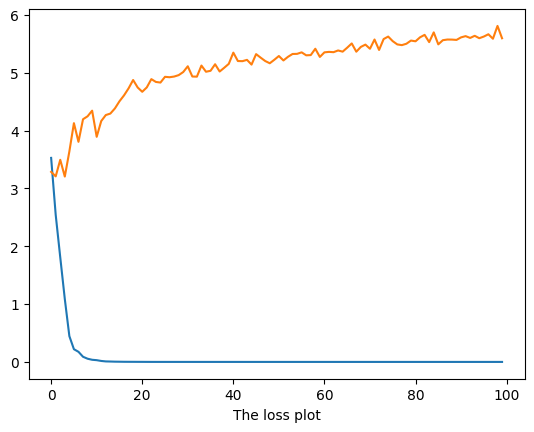

In [15]:
import matplotlib.pyplot as plt
plt.plot(df.train_loss)
plt.plot(df.val_loss)
plt.xlabel(f"The loss plot")
plt.show()

In [17]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)

In [16]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from torch.nn.functional import softmax

# # Load pre-trained BERT model and tokenizer
# model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name)

# # Sample text for sentiment analysis
# text = "I hate using BERT for sentiment analysis!"

# # Tokenize input text and convert to tensor
# tokens = tokenizer(text, return_tensors='pt')
# input_ids = tokens['input_ids']
# attention_mask = tokens['attention_mask']

# # Make prediction
# with torch.no_grad():
#     output = model(input_ids, attention_mask=attention_mask)

# # Get probabilities for each sentiment class
# probs = softmax(output.logits, dim=1).squeeze().tolist()

# # Map probabilities to sentiment labels
# sentiment_labels = ['Negative', 'Neutral', 'Positive']
# predicted_sentiment = sentiment_labels[probs.index(max(probs))]

# print(f"Predicted sentiment: {predicted_sentiment}")